In [59]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import norm, skew 
from scipy.special import boxcox1p
#inv - inv_boxcox1p(y, 2.5)
boxcox_lambda = 1.6
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

In [25]:
df = pd.read_csv('../housing.data', sep='\s+', header=None, names=['CRIM', 'ZN', 'INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV'])

In [26]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [27]:
df['MEDV'] = boxcox1p(df['MEDV'], boxcox_lambda)

In [28]:
for i in df.columns[:-1]:
    print(i)
    print(df[i].skew(), df[i].kurt())
    if i != 'CHAS' and (abs(df[i].skew()) > 0.75):
        df[i] = np.log1p(df[i])
        print(df[i].skew(), df[i].kurt())
    
    print('--------------------------')

CRIM
5.223148798243851 37.13050912952203
1.2692005882725572 0.5045535413312598
--------------------------
ZN
2.2256663227354307 4.031510083739155
1.1934513868588792 -0.3978413378913239
--------------------------
INDUS
0.29502156787351164 -1.2335396011495188
--------------------------
CHAS
3.405904172058746 9.638263777819526
--------------------------
NOX
0.7293079225348787 -0.06466713336542629
--------------------------
RM
0.40361213328874385 1.8915003664993404
--------------------------
AGE
-0.5989626398812962 -0.9677155941626912
--------------------------
DIS
1.0117805793009007 0.4879411222443908
0.33156144277059646 -0.9050971244339001
--------------------------
RAD
1.0048146482182057 -0.8672319936034931
0.5327599614480961 -0.8616338868557682
--------------------------
TAX
0.669955941795016 -1.1424079924768082
--------------------------
PTRATIO
-0.8023249268537809 -0.28509138330538875
-1.0029822002725293 0.20447932221716103
--------------------------
B
-2.8903737121414492 7.226817549

In [29]:
num_features = ['CRIM', 'ZN', 'INDUS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']

In [30]:
data_num = df[num_features]

In [47]:
data_catg = pd.get_dummies(df['CHAS'], prefix='CHAS')

In [49]:
y = df['MEDV']

In [51]:
data = pd.concat([data_num, data_catg], axis=1)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.2, random_state = 101)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (404, 14)
X_test : (102, 14)
y_train : (404,)
y_test : (102,)


In [53]:
X_train

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,CHAS_0,CHAS_1
288,0.044878,3.979682,5.32,0.405,6.315,45.6,2.118326,1.945910,293.0,2.867899,5.986201,2.151762,1,0
72,0.087681,0.000000,10.81,0.413,6.065,7.8,1.838532,1.609438,305.0,3.005683,5.971032,1.874874,1,0
471,1.617091,0.000000,18.10,0.532,6.229,90.7,1.410816,3.218876,666.0,3.054001,5.982247,2.629728,1,0
176,0.067864,0.000000,4.05,0.510,6.020,47.2,1.516204,1.791759,296.0,2.867899,5.976934,2.407846,1,0
320,0.154950,0.000000,7.38,0.493,6.426,52.3,1.712067,1.791759,287.0,3.025291,5.986201,2.104134,1,0
55,0.013025,4.510860,1.22,0.403,7.249,21.9,2.271775,1.791759,226.0,2.939162,5.983760,1.759581,1,0
224,0.274088,0.000000,6.20,0.504,8.266,78.3,1.359540,2.197225,307.0,2.912351,5.955967,1.637053,1,0
57,0.014218,4.615121,1.32,0.411,6.816,40.5,2.232678,1.791759,256.0,2.778819,5.976097,1.599388,1,0
312,0.232452,0.000000,9.90,0.544,6.023,90.4,1.343909,1.609438,304.0,2.965273,5.984692,2.543176,1,0
233,0.286284,0.000000,6.20,0.507,8.247,70.4,1.537276,2.197225,307.0,2.912351,5.940040,1.599388,1,0


In [56]:
stdSc = StandardScaler()
X_train.loc[:, num_features] = stdSc.fit_transform(X_train.loc[:, num_features])
X_test.loc[:, num_features] = stdSc.transform(X_test.loc[:, num_features])

In [57]:
X_train

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,CHAS_0,CHAS_1
288,-0.746339,1.860810,-0.854602,-1.294726,0.060300,-0.799422,1.539282,-0.141174,-0.673066,-0.790480,0.309189,-0.633320,1,0
72,-0.703539,-0.601161,-0.054399,-1.224165,-0.311287,-2.138503,0.854874,-0.591596,-0.602036,0.387579,0.288695,-1.162986,1,0
471,0.825775,-0.601161,1.008165,-0.174563,-0.067526,0.798264,-0.191367,1.562891,1.534767,0.800705,0.303847,0.280994,1,0
176,-0.723354,-0.601161,-1.039712,-0.368607,-0.378173,-0.742741,0.066422,-0.347529,-0.655308,-0.790480,0.296670,-0.143451,1,0
320,-0.636274,-0.601161,-0.554343,-0.518550,0.225285,-0.562072,0.545526,-0.347529,-0.708581,0.555232,0.309189,-0.724429,1,0
55,-0.778190,2.189416,-1.452203,-1.312367,1.448551,-1.639004,1.914638,-0.347529,-1.069647,-0.181177,0.305891,-1.383535,1,0
224,-0.517144,-0.601161,-0.726336,-0.421528,2.960169,0.358989,-0.316796,0.195249,-0.590198,-0.410415,0.268341,-1.617921,1,0
57,-0.776997,2.253915,-1.437627,-1.241805,0.804961,-0.980091,1.819000,-0.347529,-0.892073,-1.552116,0.295538,-1.689973,1,0
312,-0.558777,-0.601161,-0.187037,-0.068721,-0.373714,0.787637,-0.355031,-0.591596,-0.607955,0.042075,0.307150,0.115425,1,0
233,-0.504949,-0.601161,-0.726336,-0.395068,2.931928,0.079128,0.117967,0.195249,-0.590198,-0.410415,0.246823,-1.689973,1,0


In [60]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [61]:
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

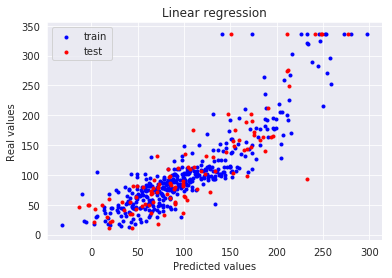

In [67]:
# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = ".", label = "train")
plt.scatter(y_test_pred, y_test, c = "red", marker = ".", label = "test")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.show()